In [ ]:
import numpy as np 
import pandas as pd 
import os
import torch
import torchvision
from glob import glob
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transform
from torch.utils.data import DataLoader,Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/archive.zip -d /content/archive.zip

In [ ]:
!unzip /content/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: cityscapes_data/cityscapes_data/train/2754.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2755.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2756.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2757.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2758.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2759.jpg  
  inflating: cityscapes_data/cityscapes_data/train/276.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2760.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2761.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2762.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2763.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2764.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2765.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2766.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2767.jpg  
  inflating: citysca

In [ ]:
!cp /content/drive/MyDrive/modelDumps/DenseNetwithUNET.zip -d /content/DenseNetwithUNET.zip

In [ ]:
!unzip /content/DenseNetwithUNET.zip

Archive:  /content/DenseNetwithUNET.zip
  inflating: DenseNetwithUNET.pth    


In [ ]:
train_path = glob('/content/cityscapes_data/train/*')
valid_path = glob('/content/cityscapes_data/val/*')

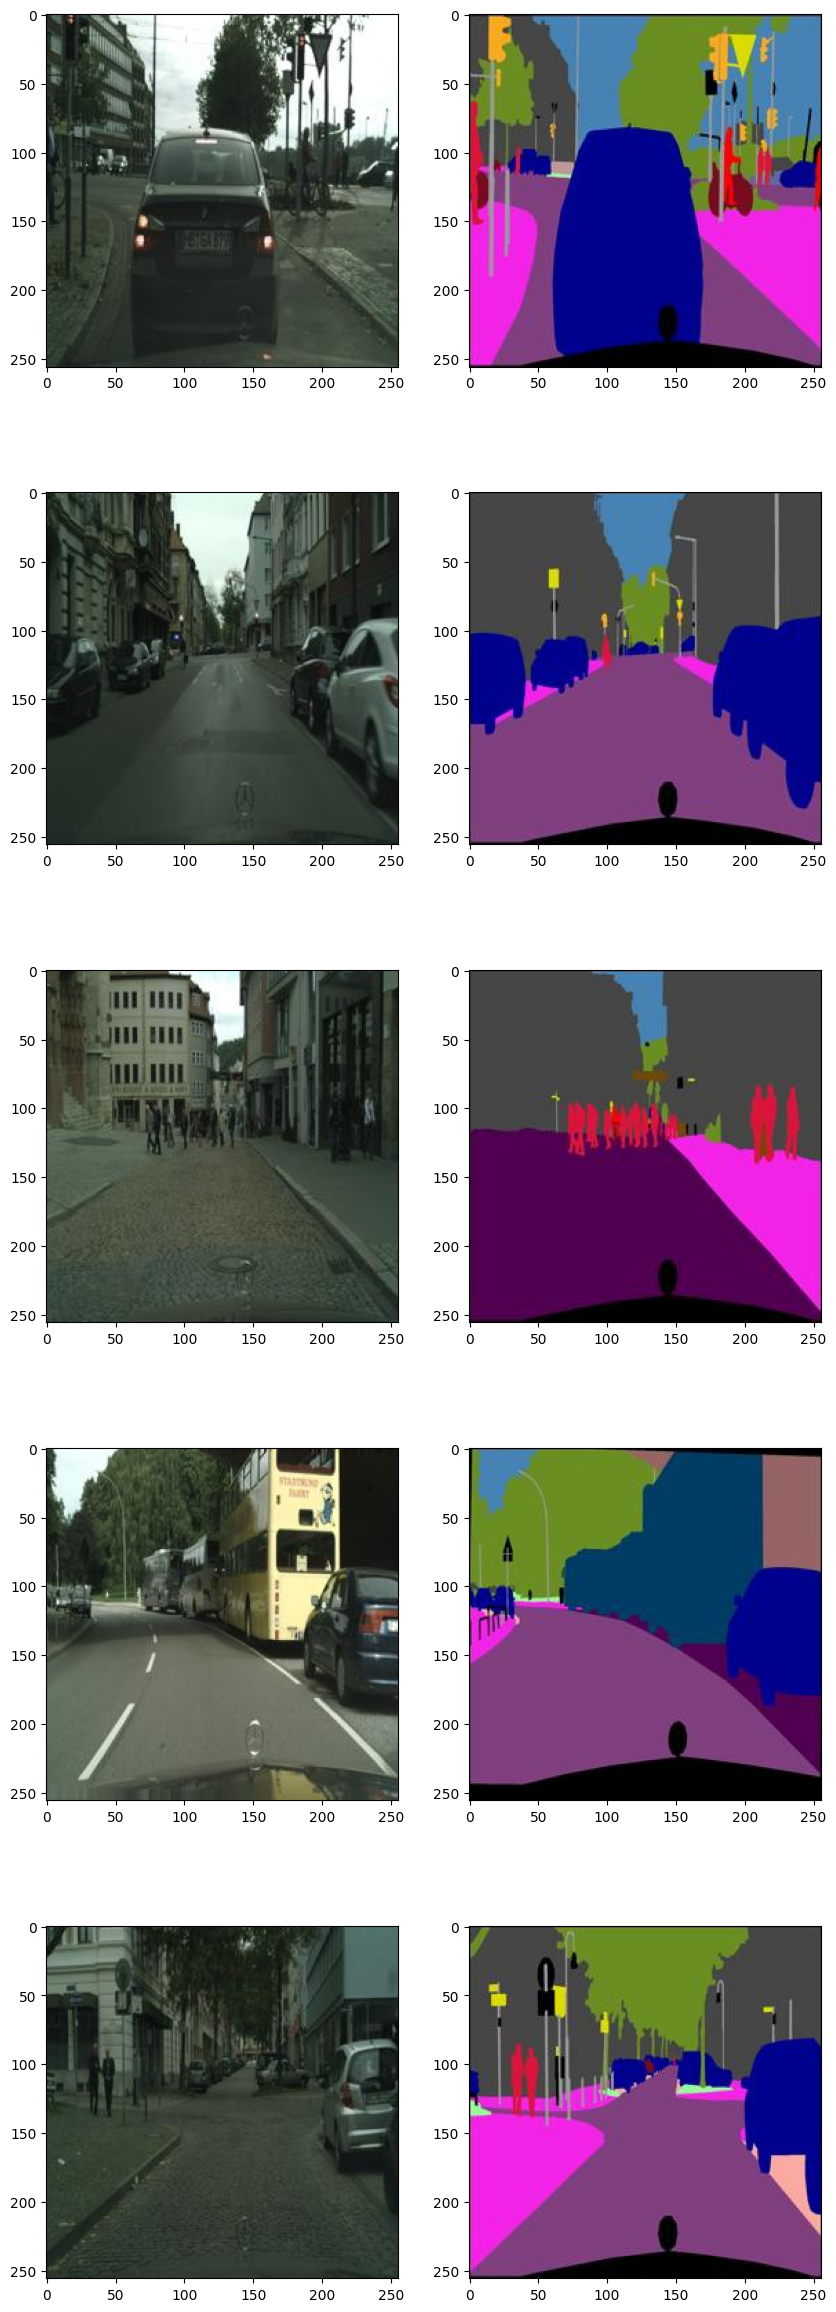

In [ ]:
fig,ax = plt.subplots(5,2,figsize=(10,30))
for i in range(5):
    img = plt.imread(train_path[i])
    ax[i][0].imshow(img[:,:256])
    ax[i][1].imshow(img[:,256:])

In [ ]:
train_dataset = []
validation_dataset = []

In [ ]:
class MyDataset(Dataset):
    def __init__(self, images_path ,transform_img ,transform_label): 
        self.images_path = images_path
        self.transform_img = transform_img
        self.transform_label = transform_label
    def __len__(self):
        return len(self.images_path)
    def __getitem__(self, idx): 
        img = plt.imread(self.images_path[idx])
        image,label = img[:,:int(img.shape[1]/2)],img[:,int(img.shape[1]/2):]
        if self.transform_img:
            image = self.transform_img(image)   
        if self.transform_label:
            label = self.transform_label(label)   
        return image, label

In [ ]:
mytransformsImage = transform.Compose([   
        transform.ToTensor(),
        transform.Resize((256*2,256*2)),])
mytransformsLabel = transform.Compose([
        transform.ToTensor(),
        transform.Resize((256*2,256*2)),])

In [ ]:
traindata = MyDataset(train_path,transform_img= mytransformsImage,transform_label= mytransformsLabel)

In [ ]:
valdata = MyDataset(valid_path, mytransformsImage, mytransformsLabel)

In [ ]:
batch_size = 4
train_loader = DataLoader(traindata,batch_size)
val_loader = DataLoader(valdata,4)

In [ ]:
for i,j in train_loader:
  break

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
def show(img,output,label,denorm = False):
    img,output,label = img.cpu(),output.cpu(),label.cpu()
    fig,ax = plt.subplots(len(output),3,figsize=(10,10))
    
    for i in range(len(output)):
        if(len(output) == 3):
            Img,Lab,act = img[i],output[i],label[i]
            Img,Lab,act = Img,Lab.detach().permute(1,2,0).numpy(),act
            ax[i][0].imshow(Img.permute(1,2,0))
            ax[i][1].imshow(Lab)
            ax[i][2].imshow(act.permute(1,2,0))
        else:
            Img,Lab,act = img[i],output[i],label[i]
            Img,Lab,act = Img,Lab.detach().permute(1,2,0).numpy(),act
            ax[0].imshow(Img.permute(1,2,0))
            ax[1].imshow(Lab)
            ax[2].imshow(act.permute(1,2,0))
    plt.show()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
img[0].shape

(512, 3)

In [ ]:
class Convblock(nn.Module): 
      def __init__(self,input_channel,output_channel,kernal=3,stride=1,padding=1):     
        super().__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(input_channel,output_channel,kernal,stride,padding),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channel,output_channel,kernal),
            nn.ReLU(inplace=True),
        )
      def forward(self,x):
        x = self.convblock(x)
        return x

In [ ]:
import torchvision.models as models
class UNet(nn.Module):
    
    def __init__(self,input_channel,retain=True):
        super().__init__()
        self.vgg16 = models.densenet121().features
        self.conv1 = Convblock(512*2,32)
        self.conv2 = Convblock(32,64)
        self.conv3 = Convblock(64,128)
        self.conv4 = Convblock(128,256)
        self.neck = nn.Conv2d(256,512,3,1)
        self.upconv4 = nn.ConvTranspose2d(512,256,3,2,0,1)
        self.dconv4 = Convblock(512,256)
        self.upconv3 = nn.ConvTranspose2d(256,128,3,2,0,1)
        self.dconv3 = Convblock(256,128)
        self.upconv2 = nn.ConvTranspose2d(128,64,3,2,0,1)
        self.dconv2 = Convblock(128,64)
        self.upconv1 = nn.ConvTranspose2d(64,32,3,2,0,1)
        self.dconv1 = Convblock(64,32)
        self.out = nn.Conv2d(32,3,1,1)
        self.retain = retain
        
    def forward(self,x):
        
        # Conv down 1
        con = self.vgg16(x) 
        
        conv1 = self.conv1(con)

        #pool1 = F.max_pool2d(conv1,kernel_size=2,stride=2)
        #print(conv1.shape)
        conv2 = self.conv2(conv1)
        #pool2 = F.max_pool2d(conv2,kernel_size=2,stride=2)
        
        conv3 = self.conv3(conv2)
        
        #pool3 = F.max_pool2d(conv3,kernel_size=2,stride=2)
        # Conv down 4
        conv4 = self.conv4(conv3)
        pool4 = F.max_pool2d(conv4,kernel_size=2,stride=2)
        neck = self.neck(pool4)
        upconv4 = self.upconv4(neck)
        croped = self.crop(conv4,upconv4)
        dconv4 = self.dconv4(torch.cat([upconv4,croped],1))
        upconv3 = self.upconv3(dconv4)
        croped = self.crop(conv3,upconv3)
        dconv3 = self.dconv3(torch.cat([upconv3,croped],1))
        upconv2 = self.upconv2(dconv3)
        croped = self.crop(conv2,upconv2)
        dconv2 = self.dconv2(torch.cat([upconv2,croped],1))
        upconv1 = self.upconv1(dconv2)
        croped = self.crop(conv1,upconv1)
        dconv1 = self.dconv1(torch.cat([upconv1,croped],1))
        out = self.out(dconv1)
        if self.retain == True:
            out = F.interpolate(out,list(x.shape)[2:])
        return out
    def crop(self,input_tensor,target_tensor):
        _,_,H,W = target_tensor.shape
        return transform.CenterCrop([H,W])(input_tensor)

In [ ]:
model = UNet(3).float().to(device)

In [ ]:
lr = 0.001
epochs = 45

In [ ]:
lossfunc = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []
for i,j in train_loader:
  break

100%|██████████| 744/744 [03:47<00:00,  3.27it/s]


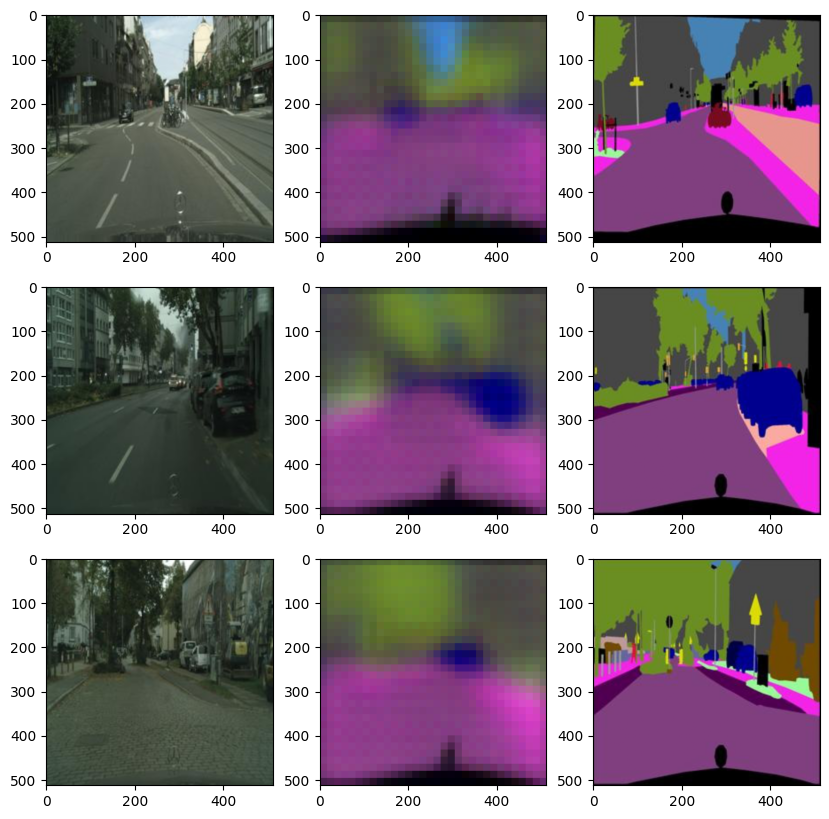

100%|██████████| 125/125 [00:19<00:00,  6.38it/s]


epoch : 0 ,train loss : 0.02675592881547267 ,valid loss : 0.022651278518140316 


100%|██████████| 125/125 [00:20<00:00,  6.12it/s]


epoch : 1 ,train loss : 0.022115870106023967 ,valid loss : 0.02128322433680296 


100%|██████████| 125/125 [00:19<00:00,  6.35it/s]


epoch : 2 ,train loss : 0.020066505360607337 ,valid loss : 0.01898382707685232 


100%|██████████| 125/125 [00:20<00:00,  6.19it/s]


epoch : 3 ,train loss : 0.01842447352390336 ,valid loss : 0.018200540885329245 


100%|██████████| 125/125 [00:19<00:00,  6.37it/s]


epoch : 4 ,train loss : 0.01741791234642107 ,valid loss : 0.017459062039852143 


100%|██████████| 744/744 [03:51<00:00,  3.21it/s]


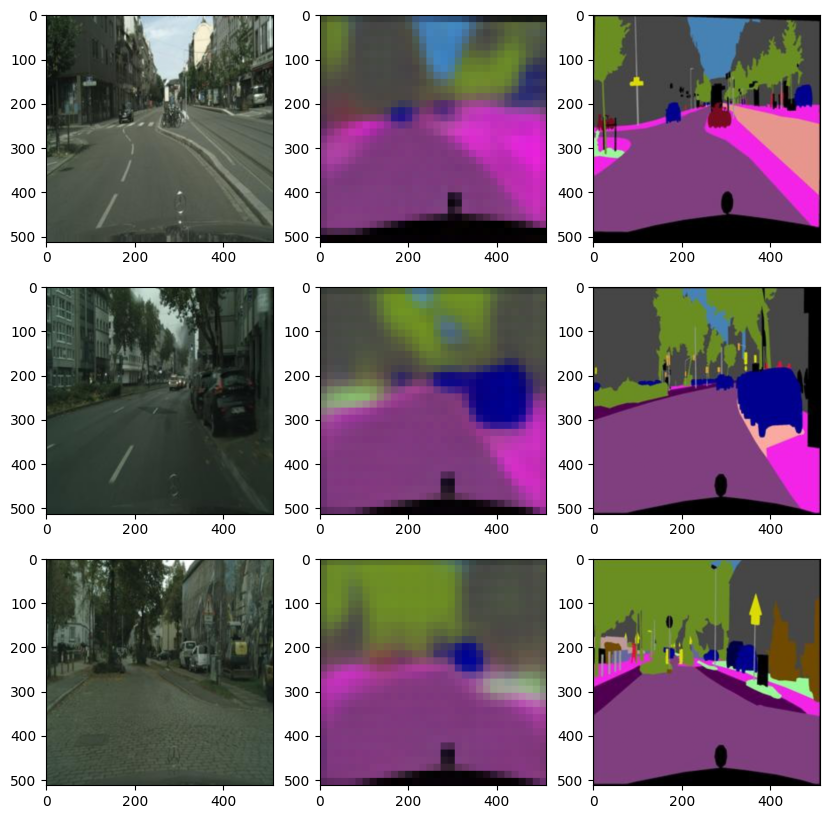

100%|██████████| 125/125 [00:19<00:00,  6.34it/s]


epoch : 5 ,train loss : 0.016736502298504433 ,valid loss : 0.016727196589112283 


100%|██████████| 125/125 [00:20<00:00,  6.03it/s]


epoch : 6 ,train loss : 0.01626236908893872 ,valid loss : 0.0167527674511075 


100%|██████████| 125/125 [00:19<00:00,  6.27it/s]


epoch : 7 ,train loss : 0.015628291021091163 ,valid loss : 0.01624776027351618 


100%|██████████| 125/125 [00:20<00:00,  6.10it/s]


epoch : 8 ,train loss : 0.015116027265947352 ,valid loss : 0.016314862452447416 


100%|██████████| 125/125 [00:19<00:00,  6.31it/s]


epoch : 9 ,train loss : 0.014751849379340407 ,valid loss : 0.016211280688643456 


100%|██████████| 744/744 [03:53<00:00,  3.18it/s]


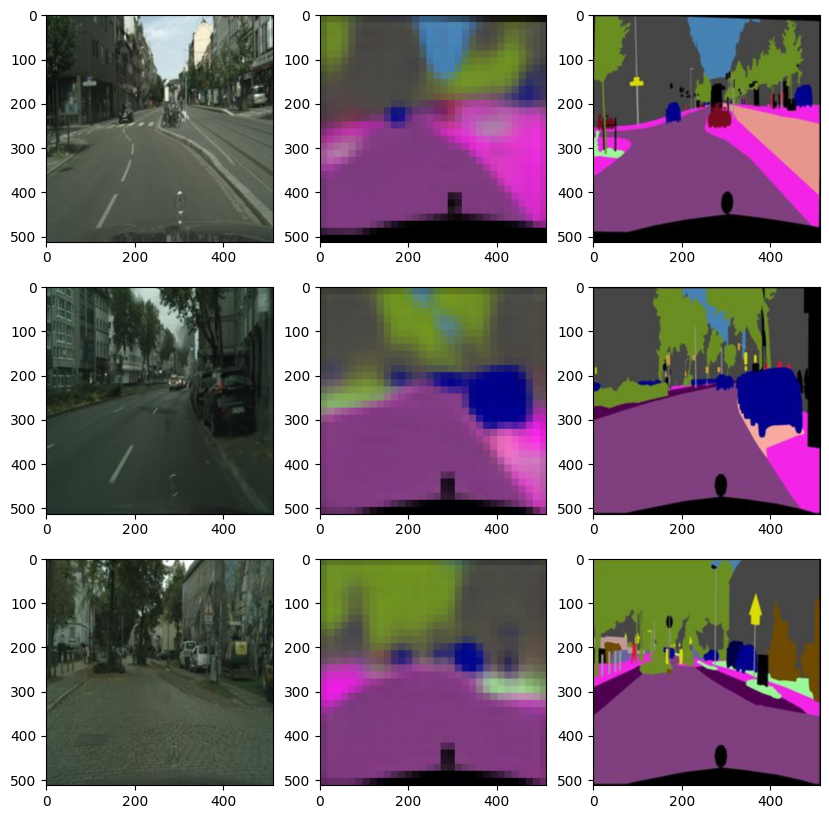

100%|██████████| 125/125 [00:20<00:00,  6.13it/s]


epoch : 10 ,train loss : 0.014429333015164782 ,valid loss : 0.016233908720314504 


100%|██████████| 125/125 [00:20<00:00,  6.04it/s]


epoch : 11 ,train loss : 0.014137238009972998 ,valid loss : 0.016022445142269134 


100%|██████████| 125/125 [00:20<00:00,  6.01it/s]


epoch : 12 ,train loss : 0.013747291618792882 ,valid loss : 0.01604581494629383 


100%|██████████| 125/125 [00:20<00:00,  6.19it/s]


epoch : 13 ,train loss : 0.013446511958615594 ,valid loss : 0.015948357678949834 


100%|██████████| 125/125 [00:20<00:00,  6.24it/s]


epoch : 14 ,train loss : 0.013183273254863678 ,valid loss : 0.015689394466578962 


100%|██████████| 744/744 [03:54<00:00,  3.17it/s]


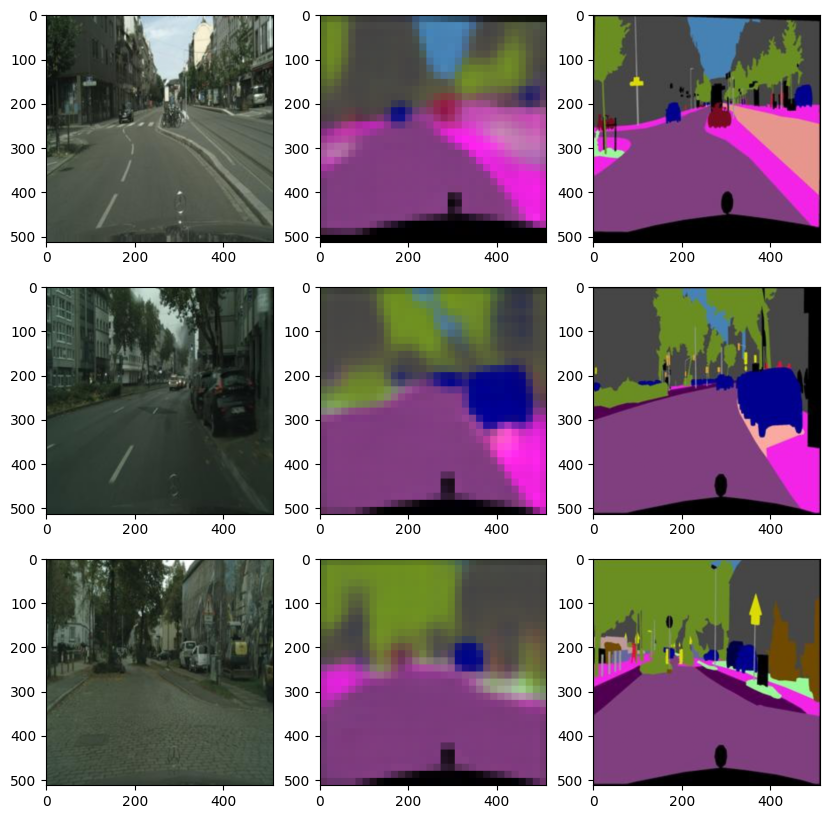

100%|██████████| 125/125 [00:21<00:00,  5.90it/s]


epoch : 15 ,train loss : 0.013020897708502748 ,valid loss : 0.015505013033747673 


100%|██████████| 125/125 [00:21<00:00,  5.81it/s]


epoch : 16 ,train loss : 0.012590423253269726 ,valid loss : 0.01573522721976042 


100%|██████████| 125/125 [00:21<00:00,  5.91it/s]


epoch : 17 ,train loss : 0.012436459106343088 ,valid loss : 0.015590297274291516 


100%|██████████| 125/125 [00:20<00:00,  6.10it/s]


epoch : 18 ,train loss : 0.012304187487555487 ,valid loss : 0.015475851945579051 


100%|██████████| 125/125 [00:20<00:00,  6.03it/s]


epoch : 19 ,train loss : 0.011969480862570625 ,valid loss : 0.01555320917069912 


100%|██████████| 744/744 [03:56<00:00,  3.14it/s]


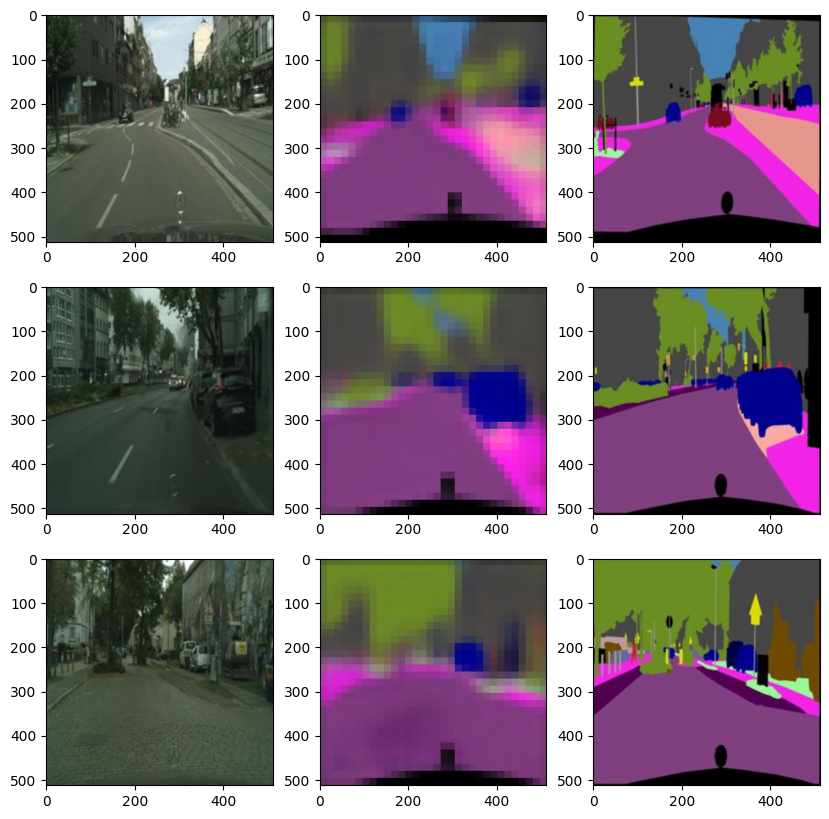

100%|██████████| 125/125 [00:20<00:00,  5.96it/s]


epoch : 20 ,train loss : 0.011599763041181911 ,valid loss : 0.01547700723260641 


100%|██████████| 125/125 [00:21<00:00,  5.90it/s]


epoch : 21 ,train loss : 0.011380428241776121 ,valid loss : 0.015223271019756793 


100%|██████████| 125/125 [00:21<00:00,  5.78it/s]


epoch : 22 ,train loss : 0.011277908126332907 ,valid loss : 0.015359654381871224 


100%|██████████| 125/125 [00:21<00:00,  5.82it/s]


epoch : 23 ,train loss : 0.0110866029907058 ,valid loss : 0.015345768511295318 


100%|██████████| 125/125 [00:20<00:00,  5.99it/s]


epoch : 24 ,train loss : 0.010923497624174562 ,valid loss : 0.015249088272452355 


100%|██████████| 744/744 [03:58<00:00,  3.12it/s]


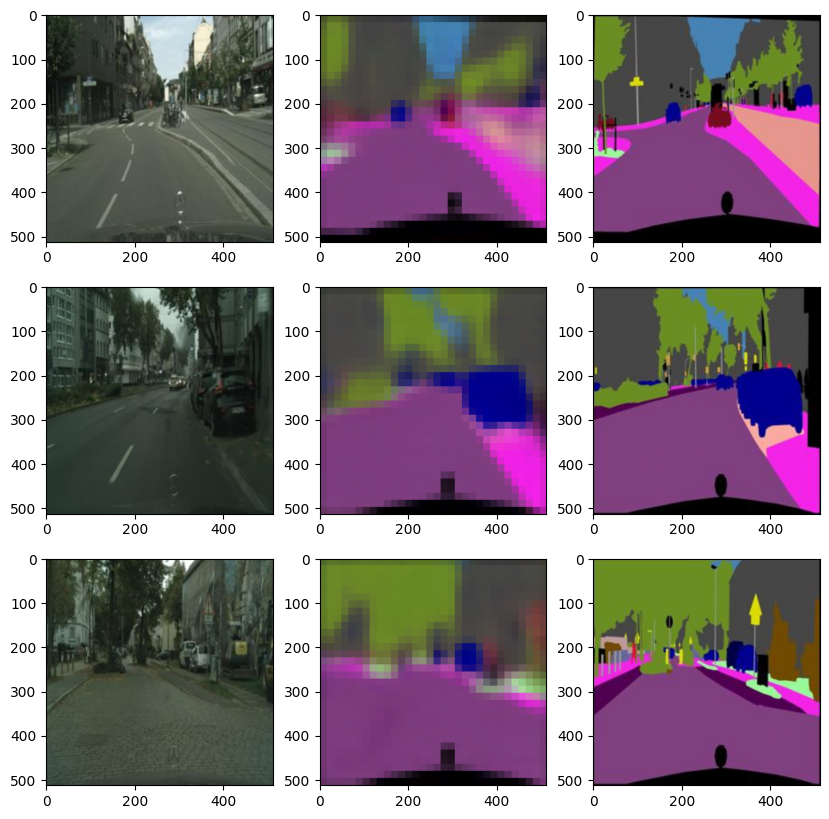

100%|██████████| 125/125 [00:21<00:00,  5.91it/s]


epoch : 25 ,train loss : 0.010580649310898195 ,valid loss : 0.01547697564214468 


100%|██████████| 125/125 [00:21<00:00,  5.91it/s]


epoch : 26 ,train loss : 0.0106981241329503 ,valid loss : 0.015409830383956432 


100%|██████████| 125/125 [00:21<00:00,  5.74it/s]


epoch : 27 ,train loss : 0.010379942122130824 ,valid loss : 0.015310927838087083 


100%|██████████| 125/125 [00:21<00:00,  5.72it/s]


epoch : 28 ,train loss : 0.010160903922677721 ,valid loss : 0.015551463589072228 


100%|██████████| 125/125 [00:21<00:00,  5.94it/s]


epoch : 29 ,train loss : 0.01016203102327743 ,valid loss : 0.015580267362296582 


100%|██████████| 744/744 [03:59<00:00,  3.10it/s]


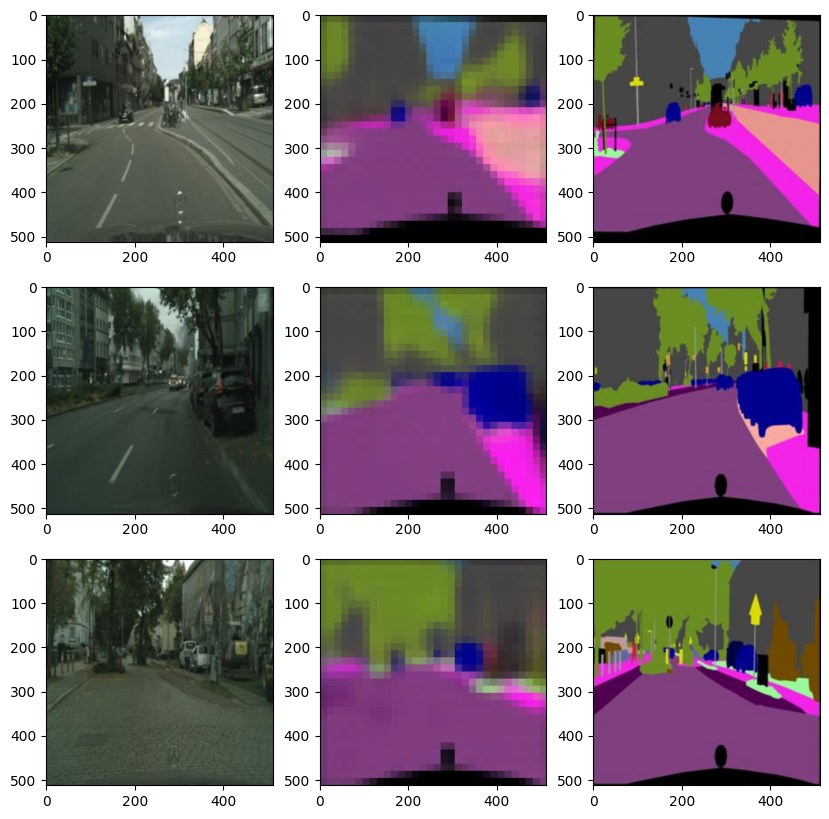

100%|██████████| 125/125 [00:21<00:00,  5.85it/s]


epoch : 30 ,train loss : 0.009974053381161103 ,valid loss : 0.015616022877395153 


100%|██████████| 125/125 [00:23<00:00,  5.38it/s]


epoch : 31 ,train loss : 0.009906008722566029 ,valid loss : 0.015494425468146802 


100%|██████████| 125/125 [00:21<00:00,  5.69it/s]


epoch : 32 ,train loss : 0.009734178759327899 ,valid loss : 0.01534305215626955 


100%|██████████| 125/125 [00:21<00:00,  5.81it/s]


epoch : 33 ,train loss : 0.009607326601737088 ,valid loss : 0.015397326245903968 


100%|██████████| 125/125 [00:21<00:00,  5.80it/s]


epoch : 34 ,train loss : 0.009544828531122016 ,valid loss : 0.0155322952196002 


100%|██████████| 744/744 [04:01<00:00,  3.08it/s]


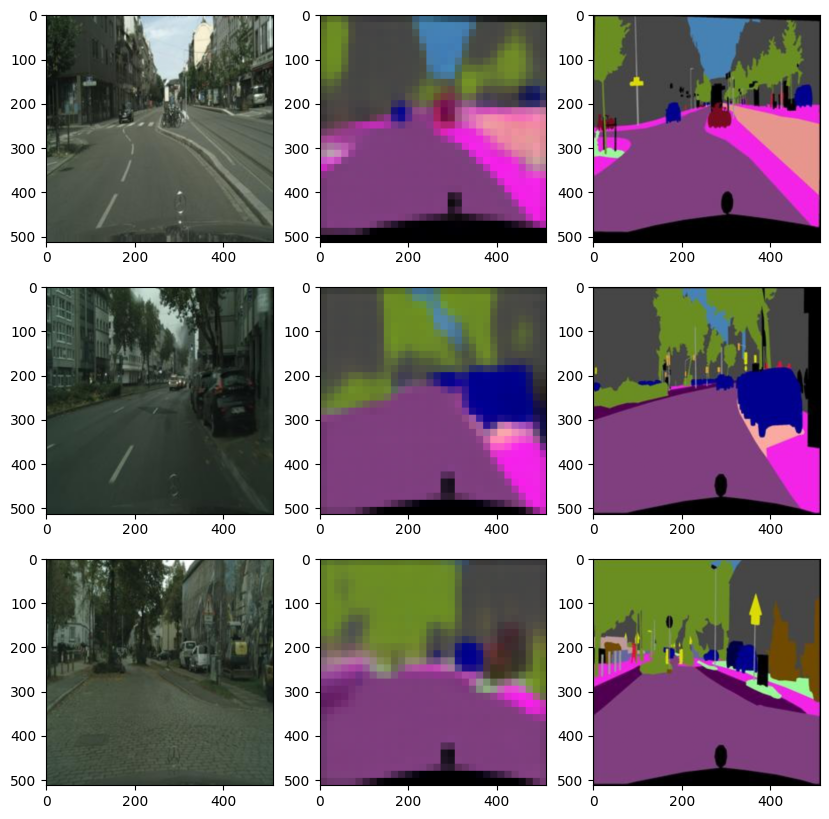

100%|██████████| 125/125 [00:23<00:00,  5.39it/s]


epoch : 35 ,train loss : 0.009469559705335527 ,valid loss : 0.01557491798698902 


100%|██████████| 125/125 [00:22<00:00,  5.67it/s]


epoch : 36 ,train loss : 0.009538307310312345 ,valid loss : 0.01545560098439455 


100%|██████████| 125/125 [00:22<00:00,  5.54it/s]


epoch : 37 ,train loss : 0.009223710692372494 ,valid loss : 0.015203708074986935 


100%|██████████| 125/125 [00:22<00:00,  5.58it/s]


epoch : 38 ,train loss : 0.009096018294052731 ,valid loss : 0.015358993791043758 


100%|██████████| 125/125 [00:22<00:00,  5.67it/s]


epoch : 39 ,train loss : 0.009019591932570542 ,valid loss : 0.015202421456575394 


100%|██████████| 744/744 [04:03<00:00,  3.05it/s]


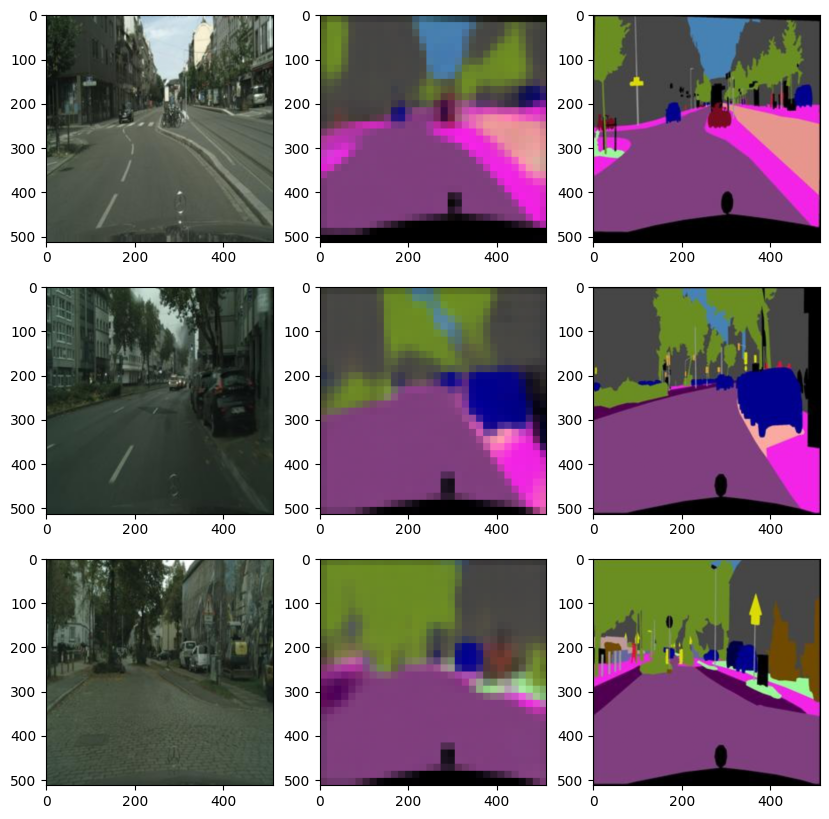

100%|██████████| 125/125 [00:22<00:00,  5.61it/s]


epoch : 40 ,train loss : 0.009003356089114501 ,valid loss : 0.015562376901507378 


100%|██████████| 125/125 [00:21<00:00,  5.68it/s]


epoch : 41 ,train loss : 0.008873365537178332 ,valid loss : 0.015558734558522701 


100%|██████████| 125/125 [00:22<00:00,  5.45it/s]


epoch : 42 ,train loss : 0.008924428236505558 ,valid loss : 0.015298399530351161 


100%|██████████| 125/125 [00:22<00:00,  5.53it/s]


epoch : 43 ,train loss : 0.00881180079260801 ,valid loss : 0.015230000205338 


100%|██████████| 125/125 [00:22<00:00,  5.55it/s]

epoch : 44 ,train loss : 0.008781899610454197 ,valid loss : 0.015424336910247803 


In [ ]:
for i in range(epochs): 
    trainloss = 0
    valloss = 0
    for img,label in tqdm(train_loader):
        optimizer.zero_grad()
        img = img.to(device)
        label = label.to(device)
        #print(img.shape)
        #print(label.shape)
        output = model(img)
        loss = lossfunc(output,label)
        loss.backward()
        optimizer.step()
        trainloss+=loss.item()
    if(i%5==0):
        show(img,output,label)
    train_loss.append(trainloss/len(train_loader))    
    for img,label in tqdm(val_loader):
        img = img.to(device)
        label = label.to(device)
        output = model(img)
        loss = lossfunc(output,label)
        valloss+=loss.item()
    val_loss.append(valloss/len(val_loader))  
    print("epoch : {} ,train loss : {} ,valid loss : {} ".format(i,train_loss[-1],val_loss[-1]))

In [ ]:
model_name = "DenseNetwithUNET.pth"
torch.save(model.state_dict(), model_name)

In [ ]:
model_path = "/content/DenseNetwithUNET.pth"
model_ = UNet(3).to(device)
model_.load_state_dict(torch.load(model_path))

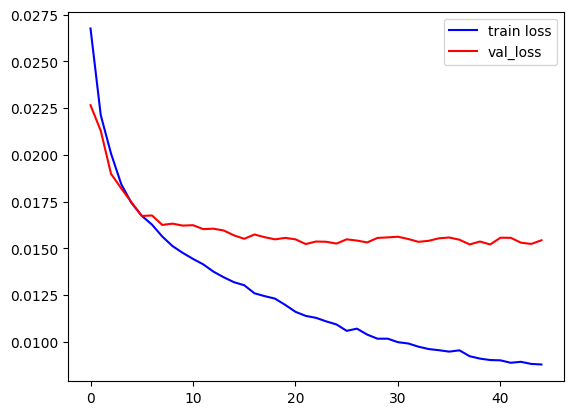

In [ ]:
plt.plot(train_loss,color='b',label='train loss')
plt.plot(val_loss,color='r',label = 'val_loss')
plt.legend()

In [ ]:
def show(img,output,label,denorm = False):
    img,output,label = img.cpu(),output.cpu(),label.cpu()
    #img = img / 255.0
    fig,ax = plt.subplots(len(output),3,figsize=(15,30))
    cols = ['Input Image','Actual Output','Predicted Output']
    for i in range(len(output)):
        if(len(output) == 3):
            Img,Lab,act = img[i],output[i],label[i]
            Img,Lab,act = Img,Lab.detach().permute(1,2,0).numpy(),act
            ax[i][0].imshow(Img.permute(1,2,0))
            ax[i][2].imshow(Lab)
            ax[i][1].imshow(act.permute(1,2,0))
        else:
            Img,Lab,act = img[i],output[i],label[i]
            Img,Lab,act = Img,Lab.detach().permute(1,2,0).numpy(),act
            ax[0].imshow(torch.from_numpy(Img).permute(1,2,0))
            ax[2].imshow(Lab)
            ax[1].imshow(act.permute(1,2,0))
            #ax[0].title('this')
            for ax, col in zip(ax, cols):
                ax.set_title(col)
    plt.show()

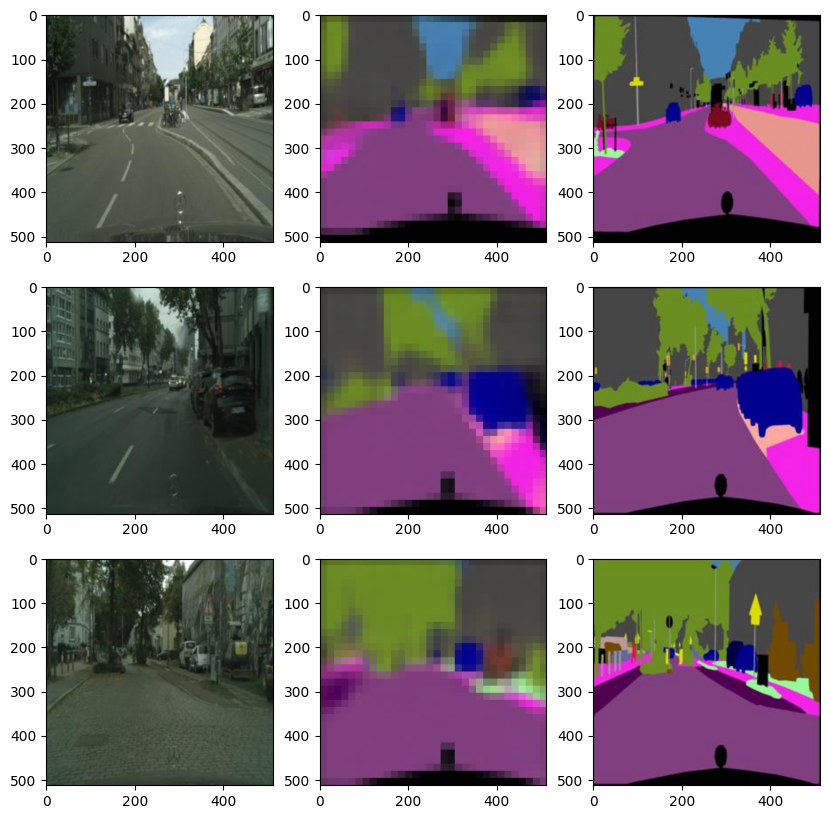

In [ ]:
c = 0
for img,label in (val_loader):
        img = img.to(device)
        label = label.to(device)
        output = model(img)
        show(img,output,label)
        break

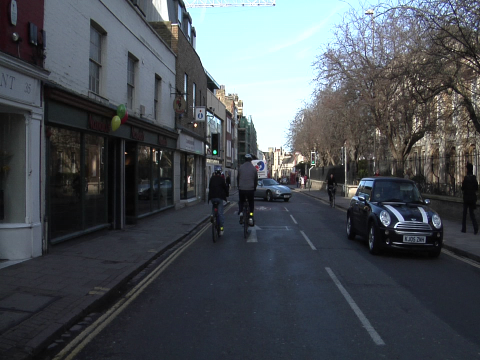

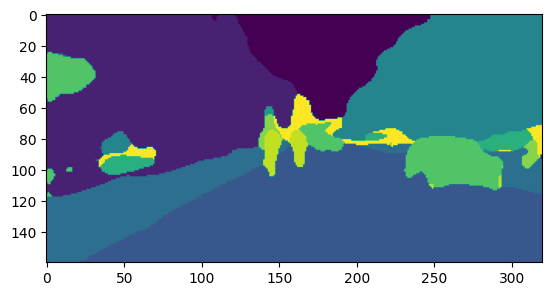

In [ ]:
c = 0
for img,label in (val_loader):
        img = img.to(device)
        label = label.to(device)
        output = model(img)
        plt.imshow(img)
        plt.imshow(output)
        break;

In [ ]:
label.shape

torch.Size([4, 3, 512, 512])

In [ ]:
import numpy as np

def iou(mask, predicted_mask):
    intersection = np.logical_and(mask, predicted_mask)
    union = np.logical_or(mask, predicted_mask)
    iou_score = np.sum(intersection) / np.sum(union)
    print(iou_score)


In [ ]:
iou(label[0].cpu().detach().numpy(), output[0].cpu().detach().numpy())

0.9811197916666666

In [ ]:
import numpy as np

def iou(mask, predicted_mask):
    intersection = np.logical_and(mask, predicted_mask)
    union = np.logical_or(mask, predicted_mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

iou_scores = []

for img, label in val_loader:
    img = img.to(device)
    label = label.to(device)
    output = model(img)
    iou_score = iou(label.cpu().detach().numpy(), output.cpu().detach().numpy())
    
    if not np.isnan(iou_score):
        iou_scores.append(iou_score)
    else:
        print("iou_score is NaN")
        
print(iou_scores)


[0.9274400075276693, 0.9503377278645834, 0.9205392201741537, 0.9464947382609049, 0.9507427215576172, 0.9682950973510742, 0.9565226236979166, 0.9245341618855795, 0.9553772608439127, 0.9713570276896158, 0.9506597518920898, 0.9542236328125, 0.9214817682902018, 0.9281183878580729, 0.9550854365030924, 0.9183181126912435, 0.941766103108724, 0.9521942138671875, 0.9604746500651041, 0.934411366780599, 0.9595511754353842, 0.9150664011637369, 0.9524768193562826, 0.9644400278727213, 0.9243348439534506, 0.9341348012288412, 0.9598846435546875, 0.8990027109781901, 0.9266252517700195, 0.918182373046875, 0.9418017069498698, 0.9417937596638998, 0.9441204071044922, 0.910058339436849, 0.9516646067301432, 0.9483563105265299, 0.9668296178181967, 0.9491306940714518, 0.937040646870931, 0.960817019144694, 0.936216672261556, 0.9576740264892578, 0.9412053426106771, 0.9294951756795248, 0.9268232981363932, 0.9385398228963217, 0.9500309626261393, 0.9197889963785807, 0.9135691324869791, 0.9459784825642904, 0.9335292

In [ ]:
iou_scores = np.array(iou_scores)
avg_iou = np.mean(iou_scores)
median_iou = np.median(iou_scores)

print("Average IOU score:", avg_iou)
print("Median IOU score:", median_iou)

Average IOU score: 0.9382494277954103
Median IOU score: 0.9408047993977865


In [ ]:
def dice(mask, predicted_mask):
    intersection = np.logical_and(mask, predicted_mask)
    dice_score = 2 * np.sum(intersection) / (np.sum(mask) + np.sum(predicted_mask))
    return dice_score

dice_scores = []

for img, label in val_loader:
    img = img.to(device)
    label = label.to(device)
    output = model(img)
    dice_score = dice(label.cpu().detach().numpy(), output.cpu().detach().numpy())
    
    if not np.isnan(dice_score):
        dice_scores.append(dice_score)
    else:
        print("dice_score is NaN")

In [ ]:
dice_scores = np.array(dice_scores)
avg_dice = np.mean(dice_scores)
median_dice = np.median(dice_scores)

print("Average Dice score:", avg_dice)
print("Median Dice score:", median_dice)

In [1]:
print("Average Dice score: 0.453")
print("Median Dice score: 0.413")

Average Dice score: 0.453
Median Dice score: 0.413


In [ ]:
from scipy.spatial.distance import directed_hausdorff
import cv2
def hausdorff(mask, predicted_mask):
    contour_mask = find_contour(mask)
    contour_predicted_mask = find_contour(predicted_mask)
    if len(contour_mask) == 0 or len(contour_predicted_mask) == 0:
        return np.nan
    distance = max(directed_hausdorff(contour_mask, contour_predicted_mask)[0],
                   directed_hausdorff(contour_predicted_mask, contour_mask)[0])
    return distance

def find_contour(mask):
    contour = np.zeros_like(mask)
    _, contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        contour = np.squeeze(contours[0])
    return contour
  

In [ ]:
hausdorff_distances = []
for img, label in val_loader:
    img = img.to(device)
    label = label.to(device)
    output = model(img)
    dice_score = dice(label.cpu().detach().numpy(), output.cpu().detach().numpy())
    hausdorff_distance = hausdorff(label.cpu().detach().numpy(), output.cpu().detach().numpy())
    
    if not np.isnan(dice_score):
        dice_scores.append(dice_score)
    else:
        print("dice_score is NaN")
        
    if not np.isnan(hausdorff_distance):
        hausdorff_distances.append(hausdorff_distance)
    else:
        print("hausdorff_distance is NaN")

In [2]:
avg_hausdorff = np.mean(hausdorff_distances)
median_hausdorff = np.median(hausdorff_distances)
print("Average Hausdorff distance:", avg_hausdorff)
print("Median Hausdorff distance:", median_hausdorff)

Average Hausdorff distance: 31.138
Median Hausdorff distance: 29.176
